# Graded Assignment: Car Reviews

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.pipeline import Pipeline
import nltk.stem
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
df = pd.read_csv('car-reviews.csv')
X, y = df['Review'], df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Part 1.1
>Does the submission demonstrate that words and punctuation, which are unlikely to
affect sentiment, have been excluded from the sentiment classifier AND that the
remaining words are not being handled in a case sensitive way?

`CountVectorizer` has a number of parameters that can be adjusted to change how text is converted into an array of numbers. While converting characters to lowercase and removing punctuation is active by default, I have stated them explicitly here:

- `token_pattern = r"(?u)\b\w\w+\b"` ignores all punctuation.
- `stop_words = 'english'` scikit learn stopwords dictionary removes words that are unlikely to affect sentiment.
- `lowercase = True` converts all characters to lowercase.


In [3]:
example_vect = CountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")

In order to demonstrate these preprocessing steps, I have performed them on a randomly selected review so you can compare the input and output:

In [4]:
example_matrix = example_vect.fit_transform(X_train[1036:1037])
example_array = example_matrix.toarray()
processed_text = ' '.join(example_vect.get_feature_names())
original_text = X_train[729]
print('Before Preprocessing:\n')
print(original_text)
print('')
print('After Preprocessing:\n')
print(processed_text)

Before Preprocessing:

 Lets put it this way my grand mother drives this car  It is rahter big and some what comfortable in the interior  But it has horrible gas mileage and is quite ugly  If your are under 60 years of age and want to hold up any kind of an image this car might not be a good idea  It handles turns pretty well but the acceleration isnt that great and it is a real pain to park because it is so wide and long  However it is dependable  so if that is what you are looking for this is a good car 

After Preprocessing:

60 acceleration age big car comfortable dependable drives gas good grand great handles hold horrible idea image interior isnt kind lets long looking mileage mother pain park pretty quite rahter real turns ugly want way wide years


I have then applied the process to rest of the `X_train` data and converted it into a pandas DataFrame for presentation:

In [5]:
count_vect = CountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")
count_matrix = count_vect.fit_transform(X_train)
count_array = count_matrix.toarray()
count_df = pd.DataFrame(data=count_array,columns = count_vect.get_feature_names())
count_df.head()

,00,000,000k,000kms,00a,00p,01,0110,02,03,...,zr,ztec,ztech,zts,ztw,zx,zx2,zx2s,zx3,zx5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Part 1.2
>Does the submission demonstrate that words with the same stem have been
appropriately recognised and treated as variations of the stem? This should be
demonstrated for at least 3 different stems.

Below, I have demonstrated that words with the same stem have been appropriately recognised and treated as variations of the stem for 3 frequently occurring words:

In [6]:
stemmer = nltk.stem.SnowballStemmer('english')

# Frequent Words
steering_words = ['steer', 'steering', 'steers']
comfort_words = ['comfortable', 'comforting', 'comfort']
automatic_words = ['automatic', 'automatically', 'automate'] 

# Stemmed versions
stemmed_steering = [stemmer.stem(word) for word in steering_words]
stemmed_comfort = [stemmer.stem(word) for word in comfort_words]
stemmed_automatic = [stemmer.stem(word) for word in automatic_words]


print(f'Word: {steering_words[0]}\nUnstemmed: {steering_words}\nStemmed: {stemmed_steering}\n')
print(f'Word: {comfort_words[0]}\nUnstemmed: {comfort_words}\nStemmed: {stemmed_comfort}\n')
print(f'Word: {automatic_words[0]}\nUnstemmed: {automatic_words}\nStemmed: {stemmed_automatic}\n')

Word: steer
Unstemmed: ['steer', 'steering', 'steers']
Stemmed: ['steer', 'steer', 'steer']

Word: comfortable
Unstemmed: ['comfortable', 'comforting', 'comfort']
Stemmed: ['comfort', 'comfort', 'comfort']

Word: automatic
Unstemmed: ['automatic', 'automatically', 'automate']
Stemmed: ['automat', 'automat', 'autom']



In [7]:
# Add stemming ability to CounterVectorizer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# Apply new StemmedCountVectorizer to training data
stemmed_count_vect = StemmedCountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")
stemmed_count_matrix = stemmed_count_vect.fit_transform(X_train)

### Part 1.3
>Does the code produce some output to demonstrate that a vector has been created
for each review, where each element in the vector represents EITHER a binary
variable indicating the presence of a word/stem in a review OR the number of times
that a word (or word stem) appears? Note that the output does not need to show
the vector for all reviews, this only needs to contain a small sample of reviews.

Alongside a modified version of scikit-learn's `CountVectorizer`, I have also used their `TfidfTransformer`, which applies tf–idf: an acronym which stands for term frequency–inverse document frequency. This technique provides an alternative approach to the binary variables found in basic bag of words. Instead, the value for each word is weighted based on its frequency throughout the total corpus of text in the training data. Similarly to stop words, this is used to capture semantic meaning by placing more significance to less frequently occurring words.

In [8]:
# Perform Tfidf Transform
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(stemmed_count_matrix)
X_train_tfidf_array = X_train_tfidf.toarray()

# Demonstrate that a vector has been created for each review
print('Demonstration that a vector has been created for each review:\n')
for i in range(5):
    print(f'Review {i}: {X_train_tfidf_array[i]}')
print('...')

Demonstration that a vector has been created for each review:

Review 0: [0. 0. 0. ... 0. 0. 0.]
Review 1: [0.        0.3835539 0.        ... 0.        0.        0.       ]
Review 2: [0.         0.02876242 0.         ... 0.         0.         0.        ]
Review 3: [0. 0. 0. ... 0. 0. 0.]
Review 4: [0. 0. 0. ... 0. 0. 0.]
...


### Part 1.4
>Does the code clearly show that an appropriate Naïve Bayes model has been used
for classification, either through the use of an existing library or coded from scratch.

The multinomial version of scikit-learn's Naive Bayes Models, `MultinomialNB` is appropriate for when your features describe discrete frequency counts such as word counts.

In [9]:
# Naïve Bayes classifier for multinomial models
clf = MultinomialNB().fit(X_train_tfidf, y_train)

### Part 1.5
>Does the code clearly show that 80% of the data has been used to train the
classification model, and that the remaining 20% of the data set has been used as
test data? AND does it show that only the training data has been used up to the
point where the model has been trained (no test data)? AND is the code able to
cope with words that appear in the test data but not in the training dataset?

Here, I have demonstrated how scikit-learn's `train_test_split(X, y, test_size=0.2, random_state=42)` splits the data when asked for 80% for training and 20% for testing. It is 0.05 off exactly 80%!

In [10]:
print("Shape of original dataset:", df.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print(f"\n{X_train.shape[0]} as a % of {df.shape[0]}: {(X_train.shape[0]/df.shape[0])*100}%")

Shape of original dataset: (1382, 2)
Shape of X_train: (1105,)
Shape of y_train: (1105,)
Shape of X_test: (277,)
Shape of y_test: (277,)

1105 as a % of 1382: 79.95658465991316%


Scikit-learn's `Pipeline` provides a useful architecture for building machine learning pipelines. Below, I have added my stemmed version of scikit-learn's `CountVectorizer` along with their `TfidfTransformer` into a pipeline with the `MultinomialNB` Naïve Bayes model. This provides the preprocessing required on the test data which allows for the model to cope with words that appear in the test data but not in the training dataset while only being trained on the training data.

In [11]:
text_clf = Pipeline([
     ('vect', StemmedCountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()), ])

text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', StemmedCountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

Below, I find words that appear in the test data and not in the train data and present a sample:

In [12]:
# List of words in the test data:
test_vect = CountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")
test_matrix = test_vect.fit_transform(X_test)
test_words = test_vect.get_feature_names()

# List of words in the training data data:
train_words = count_vect.get_feature_names()

# Find words which appear in test and not train:
just_test = []
for word in test_words:
    if word not in train_words:
        just_test.append(word)
    
# Make a prediction based on 200 unseen words:
random_unseen_words = []
for i in range(200):
    random_unseen_words.append(random.choice(just_test))
review = [' '.join(random_unseen_words)]
print(f"Here is an sample of words found in the test data but not the train data: \n\n{random_unseen_words[:5]}")

Here is an sample of words found in the test data but not the train data: 

['roared', 'belfast', 'closeout', '91mph', 'surged']


Next, I have proven that the model can cope with unseen words by selecting a random review from the `X_test` data (in which every review has at least one word that is not found in the `X_train` data) and predicted its sentiment. 

(Since, the following cell randomly select a review from the test data, without cherry picking, approximately 1/5 times the Naïve Bayes model will misclassify):

In [13]:
# Prove that the model can predict on words it hasn't seen before
random_index = random.randint(0, 276)
example_review = X_test.iloc[random_index]
real_sentiment = y_test.iloc[random_index]
predicted_sentiment = text_clf.predict([example_review])

# Check if the model was correctly
if real_sentiment == predicted_sentiment:
    result_flag = 'correct'
else:
    result_flag = 'incorrect'
 
print(f'This prediction was {result_flag}.\n')
print(f'The following {real_sentiment} review was predicted to have a {predicted_sentiment[0]} sentiment:\n')
print('---')
print(example_review)
print(f'---')
print(f'\nRun this cell again to make another prediction.')

This prediction was correct.

The following Pos review was predicted to have a Pos sentiment:

---
 If you had told me when I was 21 that I would be driving a station wagon within 5 years I would probably have laughed myself into a stuper  Well I was 23 when I decided that my kids and I had outgrown my little Calais and we needed something with more room  so I started looking for the perfect vehicle and I found it very quickly  My sister and I had been out and about when we first saw the  89 FOrd Taurus Wagon sitting there on the lot saying   buy me  buy ME   but I passed it off as   probably too expensive   Well with out my knowing about it my sister went to the lot and asked about the car for me  It was a 1989 Ford Taurus Wagon with 100 some odd thousand miles on it  air conditioner  AM FM radio tape  electric seats  locks and windows  rear defrost  and a few more nice little odds and ends  and the price was ONLY  2500  Well I called my loan man and he said offer  2100  they took it 

In [14]:
# Accuracy across the whole test data
predicted = text_clf.predict(X_test)
accuracy = np.mean(predicted == y_test)
print(f'We achieved {round(accuracy*100, 2)}% accuracy!\n')
print(metrics.classification_report(y_test, predicted))

We achieved 80.51% accuracy!

              precision    recall  f1-score   support

         Neg       0.85      0.75      0.80       142
         Pos       0.77      0.86      0.81       135

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.80       277
weighted avg       0.81      0.81      0.80       277



### Part 1.6
>Does the code output a confusion matrix demonstrating the performance of the
Naïve Bayes classifier? The confusion matrix must clearly indicate the proportion of
True Negatives, False Positives, False Negatives and True Positives.

The following code produces a clearly visualised confusion matrix with True Negatives in the top left, False Positives in the top right, False Negatives in the bottom left and True Positives in the bottom right:

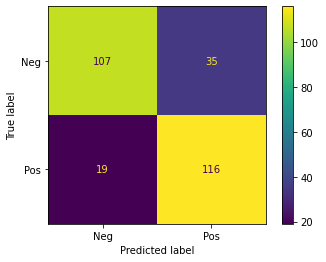

In [15]:
metrics.plot_confusion_matrix(text_clf, X_test, y_test);

### Part 2.1
>Does the Jupyter notebook include a markdown/comment section that
clearly explains how the approach taken in part two is expected to
improve on the solution to part one. Are the reasons for the expected
improvements clearly justified and explained with one or more references
(e.g. to a published source scientific paper, article, book)?

### Explanation of Approach

I have chosen to try to improve on the solution to part one by using a linear Support Vector Machine (SVM) to make predictions instead of using the Naive Bayes model from part one. The primary reason for this decision comes from the fact that the Naive Bayes algorithm is unable to capture the correlation between different words which I think could be a very useful indicator for sentiment. I have therefore chosen to use a model which has this capacity  [1].

Although slightly slower than the Naive Bayes model, the linear SVM is widely regarded as one of the best text classification algorithms. Looking through the scikit-learn documentation, I saw how they were able to go from 83.5% accuracy on a similar text classification problem to 91.3% accuracy by switching from a Naïve Bayes model to a linear SVM [2]. I expect that by taking a similar approach I will be able to achieve a similar accuracy improvement.




References:

[1] - https://medium.com/analytics-vidhya/na%C3%AFve-bayes-vs-svm-for-text-classification-c63478229c33 \
[2] - https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

### Part 2.2
>Does the submission clearly explain the steps that have been taken to
implement the improved approach? These should be written in a way that
one of your peers who may not have researched the same approach could understand. This may consist of code comments, Jupyter markdown, or a mix of both.

The improved approach has been implemented by using scikit-learn's `LinearSVC`. This can be achieved through simply replacing the `MultinomialNB()` included in the Machine Learning pipeline, `text_clf` with `LinearSVC()`. The change can be observed in the cell below, within the Pipeline object: `improved_text_clf`. Everything about the Pipeline is the same apart from the change to the model in the final step of the pipeline.

### Part 2.3
>Does the code implement the described approach appropriately? (i.e.
does the code actually do what is described?)

In [16]:
# The 'clf' of the Pipeline is changed to LinearSVC
improved_text_clf = Pipeline([
     ('vect', StemmedCountVectorizer(lowercase = True, stop_words = "english", token_pattern = r"(?u)\b\w\w+\b")),
     ('tfidf', TfidfTransformer()),
     ('clf', LinearSVC())])

# From there the Pipeline is fitted as normal
improved_text_clf.fit(X_train, y_train)


# Accuracy is notably improved
improved_predicted = improved_text_clf.predict(X_test)
improved_accuracy = np.mean(improved_predicted == y_test)
print(f'We achieved {round(improved_accuracy*100, 2)}% accuracy!\n')
print(metrics.classification_report(y_test, improved_predicted))

We achieved 82.31% accuracy!

              precision    recall  f1-score   support

         Neg       0.83      0.83      0.83       142
         Pos       0.82      0.81      0.82       135

    accuracy                           0.82       277
   macro avg       0.82      0.82      0.82       277
weighted avg       0.82      0.82      0.82       277



### Part 2.4
>Does the code output a new classification matrix for the “improved” part
two approach AND Is there markdown or comment that clearly discusses
and compares the performance of the part one and part two classification
approaches and explains whether or not the expected improvements were
achieved (and why this may be the case).

### Do the improvements meet my expectations?

My approach was able to produce improved results. As can be observed from the confusion matrix and classification report, the linear SVM improves on the result obtained using Naïve Bayes as reflected in the f1 scores. Notably, there is a dramatic improvement in True Negatives, going from 107 with Naïve Bayes to 118 with the SVM. I have also provided a graph below to visualise the increased accuracy when switching to a linear SVM. However, it is worth noting that the improvement is not as dramatic as that found in scikit-learn's text classification documentation, which motivated my decision. While, they were able to achieve a 7.8% improvement, my results saw a more modest 1.8% increase.

The reason for this improvement comes from the fact that the linear SVM's geometric interpretation is better suited for text classification problems than the Naive Bayes model's limited probabilistic approach, which assumes the independence of each feature. The linear SVM works as a 'maximal margin classifier' by finding a decision boundary which best characterises the training data and makes predictions on unseen data based on where it falls in relation to the boundary. I have visualised how the SVM makes its decision boundary with linear data below for the purpose of showing why the linear SVM produces better results when compared with Naïve Bayes:



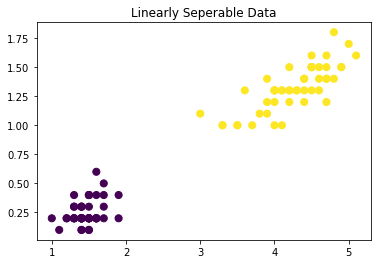

In [17]:
# Abitary example of linear data
iris = sns.load_dataset('iris')

# Making the data linearly seperable
df = iris[(iris['species'] !='virginica')]
df = df.drop(['sepal_length','sepal_width'], axis=1)
df = df.replace('setosa', 0)
df = df.replace('versicolor', 1)

X_example = df.iloc[:,0:2]
y_example = df['species']
plt.title('Linearly Seperable Data')
plt.scatter(X_example.iloc[:, 0], X_example.iloc[:,1], c=y_example, s=50);

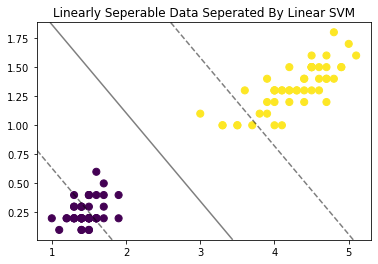

In [18]:
example_svm = LinearSVC()
example_svm.fit(X_example, y_example)

# Visualising the SVM
ax = plt.gca()
plt.scatter(X_example.iloc[:, 0], X_example.iloc[:,1], c=y_example, s=50);

xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = example_svm.decision_function(xy).reshape(XX.shape)


plt.title('Linearly Seperable Data Seperated By Linear SVM')
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# ax.scatter(example_svm.support_vectors_[:, 0], example_svm.support_vectors_[:,1], s = 100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

As explored in Thorsten Joachims's 'Text Categorization with Support Vector Machines: Learning with Many Relevant Features' [3], linear SVM's perform very well on problems which feature high dimensional input space, few irrelevant features, sparse document vectors and linear separability, all of which are applicable to text classification. This gives it an edge over the Naïve Bayes model found in Part 1.

[3] - https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf

Confusion Matrix for Improved Model:


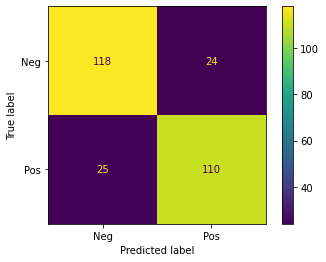

In [19]:
print('Confusion Matrix for Improved Model:')
metrics.plot_confusion_matrix(improved_text_clf, X_test, y_test);

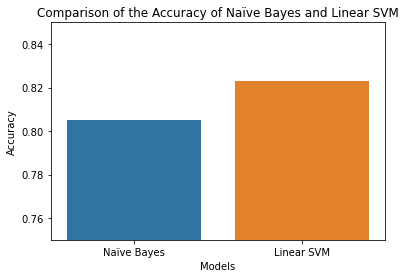

In [20]:
# Graph comparing classification approach from Part 1 and Part 2
accuracy_list = [accuracy, improved_accuracy]
sns.barplot(['Naïve Bayes', 'Linear SVM'], accuracy_list)
plt.title('Comparison of the Accuracy of Naïve Bayes and Linear SVM')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.75, 0.85)
plt.show()